In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.drawing.image import Image

%matplotlib inline

In [2]:
sns.set(font='IPAEXGothic')

## データを作る

In [3]:
data_size = 500
df = pd.DataFrame(data={
    'rank': np.floor(np.random.normal(10, 3, data_size)),
    'value': np.random.normal(0, 5, data_size),
})
df.head()

,rank,value
0,12.0,-6.040885
1,8.0,-2.232702
2,18.0,3.752968
3,9.0,7.284688
4,8.0,-5.669342


## データフレームからヒストグラムを表示

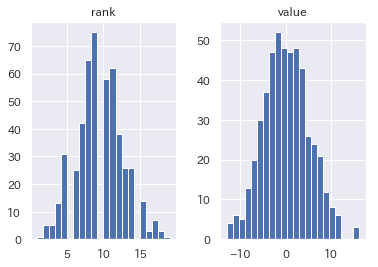

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2)
subplots = df.hist(ax=ax, bins=int(np.sqrt(data_size)))
fig.savefig('./dist/hist.png')

## 一つだけヒストグラムを表示

### Pandas経由

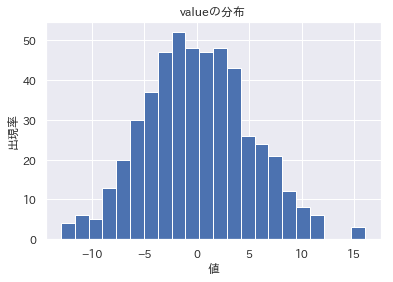

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
subplots = df.hist(column='value', ax=ax, bins=int(np.sqrt(data_size)))
ax.set_title('valueの分布')
ax.set_ylabel('出現率')
ax.set_xlabel('値')
fig.savefig('./dist/hist_value_pandas.png')

### Seaborn経由

c:\users\delta\.virtualenvs\exceleditorenv-u9juyecq\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


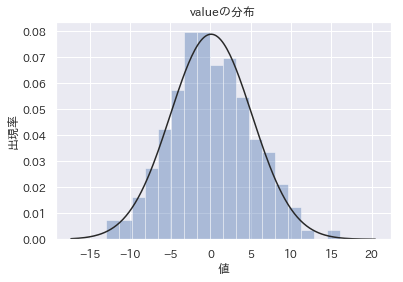

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.distplot(df['value'].values, kde=False, fit=stats.norm, ax=ax)
ax.set_title('valueの分布')
ax.set_ylabel('出現率')
ax.set_xlabel('値')
fig.savefig('./dist/hist_value_seaborn.png')

### 平均、分散の取得

In [7]:
mean = df['value'].values.mean()
var = df['value'].values.var()
mean, var

(0.08975321075444935, 25.689106002795715)

## エクセルファイルへ画像を貼り付け

In [186]:
excel_path = './dist/histogram.xlsx'
df.to_excel(excel_path)

In [187]:
wb = openpyxl.load_workbook(excel_path)
ws = wb.active
img = Image('./dist/hist_value_pandas.png')
ws.add_image(img, 'A1')
wb.save(excel_path)

## エクセル上でヒストグラムを作成

In [204]:
excel_path = './dist/histogram_excel.xlsx'
df.to_excel(excel_path, sheet_name='data')
wb = openpyxl.load_workbook(excel_path)
data_ws = wb['data']

### 集計する

In [205]:
summary_ws = wb.create_sheet('summary')

data_num = len(data_ws['A'])
data_range = f'data!B1:B{data_num}'
min_ = f'=MIN({data_range})'
max_ = f'=MAX({data_range})'
mean = f'=AVERAGE({data_range})'
std = f'=SQRT(_xlfn.STDEV.P({data_range}))'

for row, name, val in zip(range(2, 7),
                          ['num', 'min', 'max', 'mean', 'std'],
                          [data_num, min_, max_, mean, std]):
    summary_ws[f'A{row}'] = name
    summary_ws[f'B{row}'] = val
summary_ws['B1'] = '=data!B1'

### ビンにまとめる

In [206]:
hist_ws = wb.create_sheet('histogram')

bins = int(np.floor(np.sqrt(data_num)))

# bin_id
hist_ws['A1'] = 'bin_id'
for i in range(1, bins+1):
    hist_ws[f'A{i+1}'] = f'{i}'

# bin
bins_cell = 'A' + str(len(hist_ws['A']))
hist_ws['B1'] = 'bin'
for row in range(2, bins+2):
    hist_ws[f'B{row}'] = f'=(summary!B$4 - summary!B$3) / {bins_cell} * A{row} + summary!B$3'

# value_prob
bin_range = f'B2:B{bins+1}'
hist_ws['C1'] = 'value_prob'
hist_ws['C2'] = f'=FREQUENCY({data_range}, {bin_range}) / summary!B$2'
hist_ws.formula_attributes['C2'] = {'t': 'array', 'ref': f'C2:C{bins+1}'}
    
# value_norm
hist_ws['D1'] = 'value_norm'
for row in range(2, bins+2):
    freq = f'=FREQUENCY({data_range}, {bin_range})'
    hist_ws[f'D{row}'] = f'=_xlfn.NORM.DIST(B{row}, data!B5, data!B6, FALSE)'

### ヒストグラムを描画する

In [213]:
bar = openpyxl.chart.BarChart()
bar.y_axis.crosses = 'max'
bar.title = 'value'
bar.x_axis.title = 'val'
bar.y_axis.title = 'prob'
bar.legend = None
counts = openpyxl.chart.Reference(hist_ws, min_col=3, min_row=2, max_row=bins+1)
bar.append(openpyxl.chart.Series(counts))
bar.set_categories(openpyxl.chart.Reference(hist_ws, min_col=2, min_row=2, max_row=bins+1))

line = openpyxl.chart.LineChart()
line.x_axis.title = None
line.add_data(openpyxl.chart.Reference(hist_ws, min_col=4, min_row=2, max_row=bins+1))
line.y_axis.axId = 200
bar += line

hist_ws.add_chart(bar, 'C1')

In [214]:
wb.save(excel_path)